# Newtrinos.jl

Nwetrinos.jl is a package for the global analysis of neutrino data

## Code Structure

The package provides three things:
- **Experimental Likelihoods** for various experiments + datasets
- **Theory modules** for computing things like flavour oscillation probabilities, atmospheric neutrino flux, etc.
- **Analysis tools** for running Frequentist and/or Baysian inference

The code is structured in an **orthogonal** and **modular** way in the following sense:

Experimental likelihoods should only be concerned about experiment specifities, but not theory or inference. Theory should only be concerned about theory but not experiments or inference. And inference should be completely agnostic about the former two as well.

This is achieved by each module (be it experimental or theory) to adhere to some specifications:

- Each module should define its parameters and priors
- Each experimental module should implement the following functions:
  - `setup(config)`
  - `forward_model(config)`
  - `ideally also plot(params, config)`

where config is a NamedTuple of all necessary theory modules.

## Example Lieklihood

This section shows an example how to set up a joint likelihood.

In [1]:
using Newtrinos

[ Info: Precompiling Newtrinos [5b289081-bab5-45e8-97fc-86872f1653a0] (cache misses: include_dependency fsize change (4), incompatible header (6), dep missing source (2))
[ Info: Setting new default BAT context BATContext{Float64}(Random123.Philox4x{UInt64, 10}(0xd2e1675699707d22, 0x2cc09a235b7b1ed9, 0x10047e71e7d31fdc, 0x28d56738d6ef9063, 0xe5f9b4214d024648, 0x6efdbcd72d526f47, 0x0000000000000000, 0x0000000000000000, 0x0000000000000000, 0x0000000000000000, 0), HeterogeneousComputing.CPUnit(), BAT._NoADSelected())


Here we specify three theory modules in our config, where we decided on a module for standard 3-flavour oscillations, and modules for computing atmospheric fluxes and Earth density profiles:

In [2]:
config = (
    osc = Newtrinos.osc.standard,
    atm_flux = Newtrinos.atm_flux,
    earth_layers = Newtrinos.earth_layers
)

(osc = Newtrinos.osc.standard, atm_flux = Newtrinos.atm_flux, earth_layers = Newtrinos.earth_layers)

Here we choose four experimental likelihoods:

In [3]:
exp_modules = (Newtrinos.deepcore, Newtrinos.kamland, Newtrinos.dayabay, Newtrinos.minos)

(Newtrinos.deepcore, Newtrinos.kamland, Newtrinos.dayabay, Newtrinos.minos)

The setup function should be called once for each module, which will cause the module to load its data into `module.assets`

In [4]:
[m.setup(config) for m in exp_modules]

4-element Vector{Nothing}:
 nothing
 nothing
 nothing
 nothing

This is enough to generate a joint likelihood for everything:

In [5]:
likelihood = Newtrinos.generate_likelihood(exp_modules, config);

Let's evaluate the likelihood! For this we also need parameter values. The following function goeas through both. experimental and theory modules and collects all parameters:

In [6]:
p = Newtrinos.get_params(exp_modules, config)

(θ₁₂ = 0.5872523687443223, θ₁₃ = 0.1454258194533693, θ₂₃ = 0.8556288707523761, δCP = 1.0, Δm²₂₁ = 7.53e-5, Δm²₃₁ = 0.0024752999999999997, atm_flux_nunubar_sigma = 0.0, atm_flux_nuenumu_sigma = 0.0, atm_flux_delta_spectral_index = 0.0, atm_flux_uphorizonzal_sigma = 0.0, deepcore_lifetime = 2.5, deepcore_atm_muon_scale = 1.0, deepcore_ice_absorption = 1.0, deepcore_ice_scattering = 1.0, deepcore_opt_eff_overall = 1.0, deepcore_opt_eff_lateral = 0.0, deepcore_opt_eff_headon = 0.0, nc_norm = 1.0, nutau_cc_norm = 1.0, kamland_energy_scale = 0.0, kamland_geonu_scale = 0.0, kamland_flux_scale = 0.0)

In [7]:
using DensityInterface

In [8]:
logdensityof(likelihood, p)

-1080.6543117055216

## Automatic Differentiation

For efficient inference, it is important to have access to gradients. therefore all code is fully differentiable via auto-diff, using the ForwardDiff package:

In [9]:
using ForwardDiff

In [10]:
ForwardDiff.gradient(p -> logdensityof(likelihood, p), p)

(θ₁₂ = -19.10245487616378, θ₁₃ = 420.73886060499404, θ₂₃ = -170.30277734032478, δCP = -0.35888949190589636, Δm²₂₁ = 687419.0875551306, Δm²₃₁ = 15034.795584326293, atm_flux_nunubar_sigma = -3.7454697695197274, atm_flux_nuenumu_sigma = -0.6494110485544047, atm_flux_delta_spectral_index = 262.8120902081794, atm_flux_uphorizonzal_sigma = 1.5904384931010436, deepcore_lifetime = -191.94268496042022, deepcore_atm_muon_scale = -1.1612509099067818, deepcore_ice_absorption = 23.215534562299336, deepcore_ice_scattering = 309.74179980457177, deepcore_opt_eff_overall = -257.1048344886879, deepcore_opt_eff_lateral = 40.41140595498514, deepcore_opt_eff_headon = -33.947486872831675, nc_norm = -25.46398416438826, nutau_cc_norm = -59.46669650099511, kamland_energy_scale = -1.3322233658320863, kamland_geonu_scale = 1.3338116809640645, kamland_flux_scale = 1.1102273782788554)

## Inference

Let's run a likelihood analysis to construct confidence contours in the (θ₂₃, Δm²₃₁) parameter space.
Here we use a conditional likelihood for illusatration. More realistically, you may want to run `Newtrinos.profile` instead for a full profile likelihood.
Examples on Bayesian Inference will follow.

In [14]:
result = Newtrinos.scan(likelihood, Newtrinos.get_priors(exp_modules, config), (θ₂₃=31, Δm²₃₁=31), p)

NewtrinosResult((θ₂₃ = [0.5235987755982988, 0.5410520681182421, 0.5585053606381853, 0.5759586531581287, 0.593411945678072, 0.6108652381980153, 0.6283185307179586, 0.6457718232379018, 0.6632251157578452, 0.6806784082777885  …  0.890117918517108, 0.9075712110370513, 0.9250245035569946, 0.9424777960769379, 0.9599310885968813, 0.9773843811168245, 0.9948376736367678, 1.012290966156711, 1.0297442586766543, 1.0471975511965976], Δm²₃₁ = [0.002, 0.002033333333333333, 0.0020666666666666667, 0.0021, 0.0021333333333333334, 0.0021666666666666666, 0.0022, 0.0022333333333333333, 0.002266666666666667, 0.0023  …  0.0027, 0.0027333333333333333, 0.002766666666666667, 0.0028, 0.0028333333333333335, 0.0028666666666666667, 0.0029000000000000002, 0.0029333333333333334, 0.002966666666666667, 0.003]), (θ₁₂ = [0.5872523687443223 0.5872523687443223 … 0.5872523687443223 0.5872523687443223; 0.5872523687443223 0.5872523687443223 … 0.5872523687443223 0.5872523687443223; … ; 0.5872523687443223 0.5872523687443223 … 0.

In [12]:
using CairoMakie

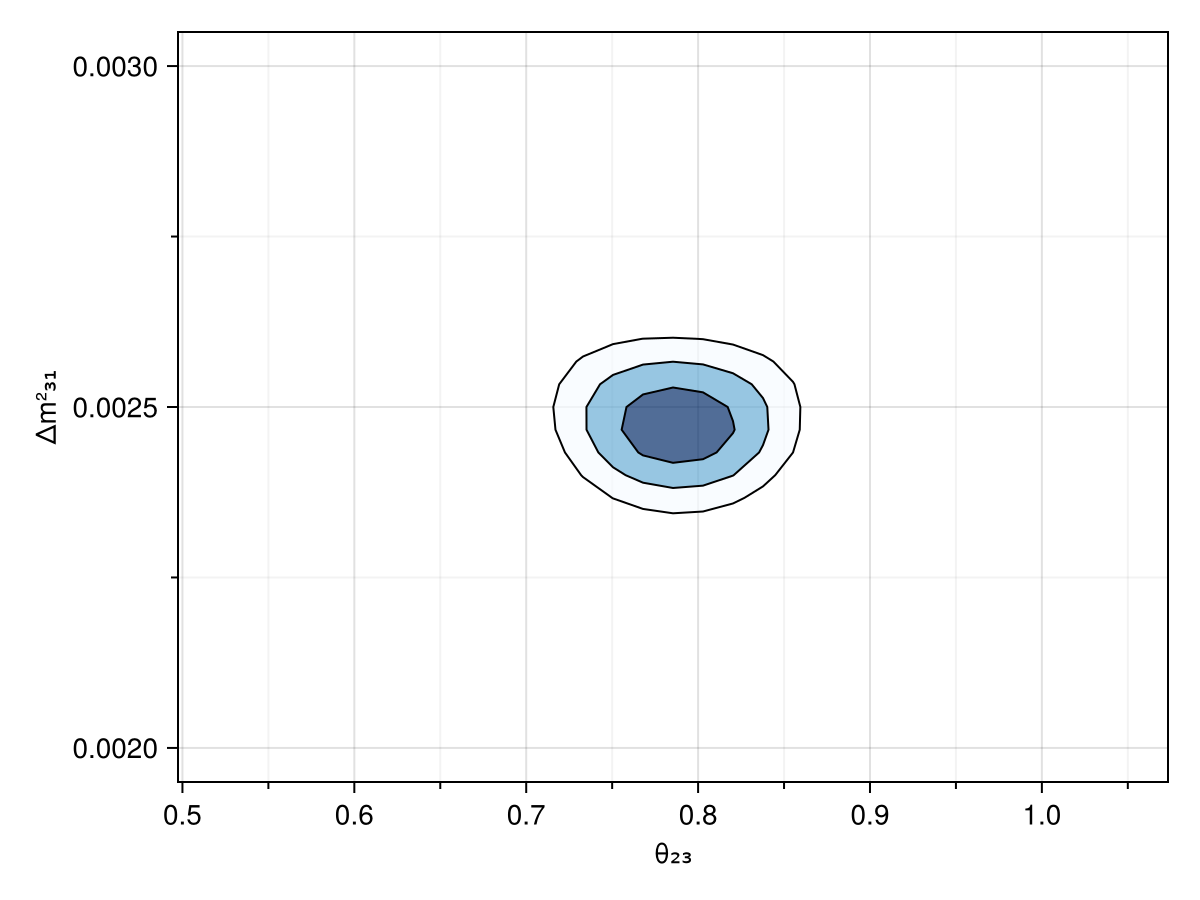

In [15]:
plot(result)